In [2]:
import os, sys

import numpy as np
import pandas as pd

import anndata
import scanpy as sc
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [3]:
def read_log2fcs_from_file(df_kid_path='DEGs_SD_vs_D_medpair_children_031325.csv', 
                           df_adult_path='DEGs_SD_vs_D_medpair_adults_031325.csv',
                          index_col=['cell_type', 'SD', 'D'], groupby=['cell_type']):
#    if cell_subtype: 
#        index_col=['ct', 'cell_type', 'SD', 'D']
#        groupby=['ct', 'cell_type']
    
    df_kid = pd.read_csv(df_kid_path, sep='\t', index_col=index_col)
    #df_kid = df_kid.groupby(['cell_type']).median()
    df_kid = df_kid[df_kid.columns[2:]]
    df_adult = pd.read_csv(df_adult_path, sep='\t', index_col=index_col)
    #df_adult = df_adult.groupby(['cell_type']).median()
    df_adult = df_adult[df_adult.columns[2:]]
    
    x_col='children'
    y_col='adults'
    df_kid1 = df_kid.groupby(groupby).median()
    df_adult1 = df_adult.groupby(groupby).median()

    cols = [x for x in df_kid1.columns if x in df_adult1]
    df_kid1 = df_kid1[cols]
    df_kid1 = df_kid1.reset_index().melt(id_vars=groupby).set_index(groupby)
    df_kid1.columns = ['gene', x_col]
    df_kid1 = df_kid1.reset_index().set_index([*groupby, 'gene'])

    df_adult1 = df_adult1[cols]
    df_adult1 = df_adult1.reset_index().melt(id_vars=groupby).set_index(groupby)
    df_adult1.columns = ['gene', y_col]
    df_adult1 = df_adult1.reset_index().set_index([*groupby, 'gene'])

    all_stats2 = pd.concat([df_kid1, df_adult1], axis=1)
    all_stats2['DEG'] = 'no'
    all_stats2.loc[all_stats2[(all_stats2[x_col] > 1) | (all_stats2[y_col] > 1)].index, 'DEG'] = 'upregulated_either'
    all_stats2.loc[all_stats2[(all_stats2[x_col] > 1) & (all_stats2[y_col] > 1)].index, 'DEG'] = 'upregulated_both'
    all_stats2.loc[all_stats2[(all_stats2[x_col] < -1) | (all_stats2[y_col] < -1)].index, 'DEG'] = 'downregulated_either'
    all_stats2.loc[all_stats2[(all_stats2[x_col] < -1) & (all_stats2[y_col] < -1)].index, 'DEG'] = 'downregulated_both'
    all_stats2.loc[all_stats2[(all_stats2[x_col] < -1) & (all_stats2[y_col] > 1)].index, 'DEG'] = 'reverse'
    all_stats2.loc[all_stats2[(all_stats2[x_col] > 1) & (all_stats2[y_col] < -1)].index, 'DEG'] = 'reverse'

    all_stats2['r'] = (all_stats2[y_col]**2 + all_stats2[x_col]**2)**0.5
    all_stats2['r2'] = all_stats2[y_col]**2 + all_stats2[x_col]**2
    all_stats2['distance'] = abs(all_stats2[y_col] - all_stats2[x_col]) / (2**0.5)
    all_stats2 = all_stats2.sort_values(by=['DEG', y_col], ascending=False)

    ## remove sex genes
    #annot = sc.queries.biomart_annotations("hsapiens", ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"] ).set_index("external_gene_name")
    #sex_genes = annot[annot.chromosome_name.isin(['X', 'Y'])].index.dropna().to_list()
    #sex_genes = pd.read_csv(f'{save_tables}Sexgenes.tsv')['0'].to_list()
    sex_genes = ["PPP2R3B", "RPL14P5", "IL3RA", "P2RY8", "SLC25A6", "DHRSX-IT1", "DHRSX", "ASMTL", "LINC00685", "PLCXD1", "ZBED1", "MIR6089", "LINC00102", "CD99", "Metazoa_SRP", "FABP5P13", "KRT18P53", "SHOX", "MIR3690", "RNA5SP498", "CD99P1", "CRLF2", "AKAP17A", "ASMT", "CSF2RA", "ASMTL-AS1", "LINC00106", "LINC02968", "CD99P1", "LINC03112", "GTPBP6", "AMD1P2", "DPH3P2", "VAMP7", "ELOCP24", "TRPC6P1", "DDX11L16", "WASH6P", "WASIR1", "IL9R", "TSPY24P", "ZNF92P1Y", "SERBP1P2", "TSPY12P", "DUX4L19", "OFD1P3Y", "RBMY2HP", "ELOCP35", "SLC9B1P1", "USP12PY", "KDM5DP1", "DUX4L17", "PRY", "ZNF736P6Y", "TUSC2P1", "PUDPP1", "CDRT15P10", "USP9Y", "PRY2", "OFD1P8Y", "RNF19BPY", "TSPY23P", "TUBB1P2", "ACTR3BP1", "RPS24P1", "RCC2P2", "ZNF736P8Y", "EIF1AY", "BPY2", "MTND1P12", "CTBP2P1", "MTND6P1", "PABPC1P5", "TSPY22P", "RCC2P1", "SHROOM2P1", "DUX4L18", "ZNF736P11Y", "OFD1P9Y", "BPY2DP", "CHEK2P1", "RBMY2UP", "ZNF886P", "ELOCP8", "OFD1P16Y", "TTTY25P", "ASS1P6", "SNX18P1Y", "MED14P1", "ZNF885P", "ARSFP1", "ZNF736P7Y", "SURF6P1", "ANKRD20A6P", "RBMY2KP", "TSPY21P", "TTTY19", "TTTY4", "MXRA5Y", "DUX4L16", "MTCYBP1", "USP9YP17", "TTTY17A", "AGPAT5P1", "FAM41AY1", "ELOCP15", "TRIM60P3Y", "MTND1P1", "PRRC2CP1", "ZNF736P10Y", "CDY12P", "MTND2P3", "CDY13P", "RBMY1KP", "ARSDP1", "TTTY5", "CDY4P", "RBMY1D", "USP9YP24", "UBE2V1P3", "FAM8A4P", "TRIM60P8Y", "MED13P1", "CYCSP46", "RNU6-303P", "RN7SL702P", "RNA5SP520", "RNA5SP521", "RNU6-109P", "RNU6-184P", "HSFY2", "GPM6BP2", "USP9YP2", "ELOCP14", "PRYP6", "XKRYP2", "USP9YP10", "RNU1-41P", "OFD1P7Y", "MTCYBP2", "ZNF839P1", "CD24P4", "RNU6-255P", "GAPDHP19", "CLUHP1", "TAF9P1", "CDY5P", "ELOCP36", "ACTG1P2", "USP9YP23", "USP9YP27", "RNU1-128P", "TRAPPC2P3", "ELOCP6", "CDY6P", "USP9YP7", "USP9YP6", "CDY7P", "USP9YP34", "USP9YP32", "CDY8P", "ELOCP12", "TRAPPC2P8", "USP9YP15", "RNU1-95P", "USP9YP16", "ACTG1P11", "ELOCP26", "CDY9P", "TAF9P2", "CLUHP2", "RNA5SP522", "RNA5SP523", "TUBB1P1", "ELOCP13", "OFD1P4Y", "RNU1-48P", "USP9YP5", "XKRYP1", "PRYP5", "ELOCP7", "USP9YP1", "GPM6BP1", "RAB9AP4", "TRAPPC2P7", "KDM5D", "HSFY1", "TGIF2LY", "RBMY1F", "CDY2A", "ZNF736P3Y", "TRIM60P9Y", "RN7SKP282", "Y_RNA", "RNU6-941P", "RNU6-521P", "SRIP3", "GOT2P5", "ATP5PFP1", "TRIM60P10Y", "ZNF736P2Y", "TRIM60P11Y", "ZNF736P1Y", "ZNF736P5Y", "BPY2C", "TTTY4C", "DAZ4", "CDY2B", "RNU6-1334P", "SRY", "TOMM22P2", "RPS4Y1", "NAP1L1P2", "ZFY", "EEF1A1P41", "PSMA6P1", "SFPQP1", "DPPA2P1", "DDX3Y", "CASKP1", "UTY", "TMSB4Y", "VCY", "DAZ3", "DAZ1", "SNORA70", "AMELY", "TBL1Y", "DAZ2", "AGKP1", "NLGN4Y-AS1", "RBMY1E", "NLGN4Y", "CDY22P", "ELOCP17", "OFD1P18Y", "TRAPPC2P4", "RAB9AP3", "USP9YP20", "RNU1-40P", "USP9YP21", "XKRYP6", "PRYP4", "ELOCP11", "CDY23P", "USP9YP26", "HSFY8P", "SNORA70", "RNU6-1314P", "CYCSP48", "VCY1B", "PNPLA4P1", "TBL1YP1", "RPS4Y2", "HSFY4P", "GAPDHP17", "TMEM167AP1", "TOMM22P1", "NEFLP1", "PRORY", "TSPY14P", "RBMY1HP", "TTTY13", "ELOCP5", "CDY10P", "USP9YP3", "USP9YP8", "CDY11P", "HSFY6P", "USP9YP18", "CDY14P", "ELOCP16", "XKRYP3", "USP9YP25", "USP9YP29", "RNU1-97P", "RAB9AP1", "TRAPPC2P9", "OFD1P11Y", "PRYP3", "RNU2-57P", "VDAC1P6", "EIF4A1P2", "KRT18P10", "SNX3P1Y", "RPL26P37", "PCDH11Y", "ELOCP9", "CDY15P", "XKRYP4", "USP9YP13", "USP9YP11", "TTTY3B", "USP9YP12", "RNU1-86P", "RAB9AP5", "TRAPPC2P10", "OFD1P12Y", "ELOCP10", "CDY1B", "CDY17P", "USP9YP35", "USP9YP31", "CDY18P", "RN7SL818P", "UBE2Q2P4Y", "LINC00265-2P", "CICP2", "RBMY2XP", "TTTY17B", "TRIM60P5Y", "ZNF736P12Y", "TTTY4B", "BPY2B", "ZNF736P4Y", "RBMY2YP", "CICP1", "LINC00265-3P", "UBE2Q2P5Y", "GOLGA2P3Y", "RN7SL725P", "CDY19P", "USP9YP36", "USP9YP33", "CDY20P", "ELOCP34", "OFD1P13Y", "TRAPPC2P5", "RAB9AP2", "USP9YP30", "RNU1-107P", "TTTY3", "USP9YP9", "USP9YP19", "XKRYP5", "CYCSP49", "SLC25A15P1", "PARP4P1", "CCNQP2", "CDY1", "RBMY1J", "RBMY1B", "RBMY1A1", "RFTN1P1", "RBMY2FP", "RBMY2BP", "TTTY11", "ARSLP1", "OFD1P6Y", "TTTY9A", "XKRY", "XKRY", "XKRYP7", "HSFY3P", "TAB3P1", "ANOS2P", "RBMY2EP", "GOLGA2P2Y", "GOLGA2P2Y", "TXLNGY", "GYG2P1", "CDY3P", "USP9YP22", "USP9YP4", "ELOCP4", "TTTY20", "TSPY4", "FAM197Y7", "FAM197Y6", "TSPY8", "TSPY3", "RBMY2CP", "RBMY2DP", "ZNF736P9Y", "FAM197Y8", "PRKY", "XKRYP7", "BCORP1", "FAM197Y8", "FAM197Y5", "FAM197Y5", "TSPY1", "FAM197Y4", "FAM197Y4", "TSPY9", "FAM197Y3", "FAM197Y3", "FAM197Y2", "TSPY10", "FAM197Y1", "TSPY25P", "TSPY16P", "TTTY22", "TSPY18P", "RBMY2OP", "RBMY2QP", "TSPY20P", "TSPY5P", "RNA5SP518", "RNA5SP519", "DUX4L31", "PCMTD1P1", "CDC27P2", "RNA5-8SP6", "DLGAP5P1", "TTTY23B", "TSPY2", "FAM197Y9", "FAM197Y9", "TSPY19P", "LINC00280", "TSPY17P", "RBMY2FP", "TTTY23", "FAM224B", "TTTY2B", "TTTY1B", "TTTY7", "TTTY8B", "TTTY10", "TTTY16", "TTTY12", "TTTY2", "TTTY7B", "ZFY-AS1", "TTTY6", "TTTY17C", "TTTY6B", "SEPTIN14P23", "FAM224A", "TXLNGY", "FAM41AY2", "LINC00278", "TTTY1", "TTTY11", "BCORP1", "LINC00279", "TTTY18", "TTTY8", "PRKY", "HSFY7P", "RBMY2AP", "STSP1", "RBMY2JP", "HSFY5P", "XGY1", "RBMY2WP", "USP9YP28", "TTTY14", "PRYP1", "OFD1P1Y", "PRYP2", "USP9YP14", "RNASEH2CP1", "XGY2", "PPP1R12BP2", "REREP1Y", "GPR143YP", "OFD1P15Y", "REREP2Y", "PPP1R12BP1", "ANKRD36P1", "OFD1P2Y", "OFD1P5Y", "TTTY9B", "RBMY2TP", "OFD1P10Y", "GOLGA6L11P", "DNM1P24", "CSPG4P2Y", "CSPG4P3Y", "SEPTIN14P22", "CSPG4P4Y", "CSPG4P1Y", "DNM1P48", "GOLGA6L16P", "TPTE2P4", "RBMY1A3P", "TSPY7P", "TSPY6P", "TSPY15P", "RBMY3AP", "RBMY2NP", "TSPY13P", "TSPY11P", "RBMY2GP", "PPP2R3B", "RPL14P5", "MTND6P12", "HADHBP1", "PRKX-AS1", "PRKX", "DRAXINP1", "VCX2", "ANAPC15P1", "GS1-600G8.3", "NOLC1P1", "IL3RA", "P2RY8", "RPS5P8", "MTCYBP12", "RPS27AP20", "RPL6P30", "SLC25A6", "AMELX", "DHRSX-IT1", "DHRSX", "SHROOM2", "RARRES2P3", "ANOS1", "ASMTL", "FAM9CP1", "RPL24P9", "FAM9B", "HCCS", "HIKESHIP1", "NLGN4X", "GOT2P7", "FAM9A", "SRPX", "LINC00685", "GRPR", "TMSB10P2", "BEND2", "RPL35AP37", "CLDN7P1", "TMEM47", "UBE2E4P", "MDM4P1", "BRK1P1", "SRSF2P1", "KLHL34", "SMPX", "CNKSR2", "SYTL5", "LINC01283", "METTL1P1", "SC4MOP", "PLLPP1", "RPS15AP40", "HMGB1P16", "GAPDHP65", "PGAM1P7", "ADGRG2", "RAI2", "RBM39P1", "CTPS2", "TNIP2P1", "GAPDHP1", "S100G", "MKI67P1", "H2AP", "RP2", "MBTPS2", "MOB1AP2", "SIAH1P1", "MAGEB17", "RPP40P1", "FAM47B", "SCML2", "CTNNBL1P1", "YBX1P8", "PYY3", "NANOGP10", "NFYCP1", "EFHC2", "MED14", "CHST7", "CHTF8P1", "CCNYL5", "CLCN5", "CHMP5P1", "MAGEB10", "ITIH6", "PTCHD1", "SYAP1", "MTMR8", "ZFRP1", "CDKL5", "CFAP47", "SSBL2P", "FAM236B", "NDP", "YY2", "ETF1P3", "YWHAZP7", "DYNLT3", "AKAP4", "MAOB", "YWHAZP8", "KPNA4P1", "VSIG4", "RPL19P20", "JADE3", "FOXR2", "SLC9A7", "HNRNPDP1", "RBMXP5", "PHKA1-AS1", "MAGEH1", "SMIM15P1", "DGKK", "NDP-AS1", "SPIN4-AS1", "PIR", "RPL23AP83", "PSMA5P1", "EDA2R", "CYSLTR1", "ATP6AP2", "SLC16A2", "TERF1P7", "LDHBP2", "MTND1P31", "TOMM20P4", "KRT8P27", "MAGED2", "KLF8", "SFR1P2", "HNRNPH3P1", "THAP12P1", "PSMA1P1", "PCNPP4", "XAGE2", "TPMTP4", "SAR1AP4", "FGF16", "P2RY10BP", "CPXCR1", "HMGN1P34", "HDAC8", "UPRT", "TUBB4BP8", "SETP4", "MTND2P25", "HDX", "CTDSPL2P1", "CALM1P1", "CORO1CP1", "EIF3MP1", "UBE2V1P7", "CYCSP43", "UBE2V1P9", "PABPC5", "PABPC1L2A", "SRIP2", "ARL13A", "EEF1A1P15", "BRWD3", "COPS8P1", "RPSAP15", "EIF4A1P10", "SHC1P1", "EDA", "CHM", "STAU2P1", "HNRNPA1P25", "PPATP2", "HNRNPDLP3", "FCF1P9", "RPS29P28", "TEX101P1", "STIP1P3", "KAT7P1", "B3GNT2P1", "POF1B", "KLHL4", "CAPZA1P3", "VDAC1P1", "RPL6P29", "WBP11P3", "IGBP1-AS2", "USP37P1", "RPS7P14", "FOXN3P2", "MAGEE1", "ATG4AP1", "BUD31P2", "PAICSP7", "RPSAP8", "MRPS22P1", "RNF19BPX", "RTL3", "POMPP1", "BRAFP1", "SERBP1P4", "USP12PX", "PDK1P2", "TBX22", "TGIF2LX", "ST13P18", "ACTR3P2", "KRT18P11", "NBDY", "DLGAP5P2", "KIF4CP", "OOEPP1", "HMGB1P32", "SH3BGRL", "GTF3C6P1", "TRAPPC13P1", "CSGALNACT2P1", "HK2P1", "ATP5MC2P4", "TRMT2B", "BRDTP1", "LRRFIP2P1", "NDUFA5P7", "TEX13B", "HNRNPDLP1", "C3orf49P1", "VDAC1P3", "XRCC6P5", "MAGEE2", "TERF1P4", "SERBP1P1", "CCNB1IP1P3", "NT5DC1P1", "SLC6A14", "XK", "SERPINA7P1", "RPL34P36", "RANBP1P1", "NLRP2B", "AP2B1P1", "ARHGAP6", "MYCLP2", "TATDN2P1", "ATG4A", "AWAT2", "PSMD10", "TUSC2P2", "LRCH2", "TUBAP6", "FUNDC1", "CCNB3", "ACTRT1P1", "POU3F4", "EIF3JP1", "SNX3P1X", "FAM236C", "P2RY10", "TPT1P13", "KRT8P17", "KRBOX4", "EFNB1", "MDH1P1", "MTCYBP31", "PPP1R2C", "CYLC1", "VEZTP1", "RIPPLY1", "MTND4P31", "PGAM4P1", "FDPSP5", "DPRXP6", "MTND6P13", "CXorf38", "RPL36P18", "EEF1A1P29", "TMEM230P1", "TMEM184CP1", "RPL7AP72", "NLRP7P1", "IMPDH1P4", "DCAF8L1", "RPL22P22", "RPL31P63", "SPIN4", "RRM2P3", "PCNAP3", "RPL7P55", "MTCO1P53", "PRPF4BP1", "DCAF12L2", "COX6CP12", "OTUD6A", "UBE2V1P16", "THOC2", "PNPLA10P", "SPRYD7P1", "GEMIN8P3", "ITM2A", "CAPZA1P1", "RPS7P13", "CBLL1P1", "LUZP4", "SPANXB1", "HSPA8P1", "RPL26P36", "MAGEC2", "VKORC1P1", "SUMO2P21", "DUTP4", "SLITRK4", "NAP1L2", "FERP1", "PHF5AP4", "HTATSF1", "OR11Q1P", "BTG3P1", "CYCSP44", "H2BP8", "TFDP3", "SNURFL", "MTND4LP1", "OR5BH1P", "YAP1P2", "IGBP1", "SPANXN3", "CT47A12", "KRT18P44", "LINC00850", "HAX1P1", "CNOT7P1", "OR7L1P", "TUBB4AP1", "ORC1P1", "SKP2P1", "WDR44", "PWWP3B", "STK24P1", "LINC01282", "SRD5A1P1", "CTDSPL2P2", "PLS3-AS1", "RAC1P4", "BRS3", "ASB12", "CT47A11", "UFM1P1", "PA2G4P1", "AMER1", "ZIC3", "RPL32P35", "RPL3P12", "SPANXC", "RPL7L1P11", "SPANXN1", "PNMA6B", "MAGEC3", "TMEM185AP1", "TRMT1P1", "MTND4P24", "OR11N1P", "HSFX1", "CMC4", "AFF2-IT1", "M6PRP1", "PGBD4P6", "ZFYVE9P1", "MAGEA8", "IDS", "CT47A7", "HNRNPH1P2", "LDOC1", "MTCP1", "MTND1P33", "RBMX2P2", "MAGEA11", "GPR50", "FAM226B", "PASD1", "IGSF1", "MTCYBP38", "MAGEA7P", "PNMA6F", "EOLA2", "FUNDC2", "NDUFB3P5", "EOLA1-DT", "RPL36AP52", "EOLA1", "SPANXD", "MTND2P39", "RRM2P4", "RNF128", "ELL2P4", "VGLL1", "ANKRD11P2", "IDSP1", "MAGEC1", "LHFPL1", "F8", "NAB1P1", "HNRNPCP10", "HDGFP1", "PRR32", "TCERG1P1", "CXorf51B", "AFF2", "HMGN5", "HMGB3P30", "MAP7D3", "RPA4", "DCAF12L1", "SETP8", "CBX1P1", "OR1AA1P", "GLUD2", "TJAP1P1", "EEF1GP5", "TBC1D8B", "RUVBL2P1", "NDUFB5P2", "MORC4", "CSGALNACT2P2", "VBP1", "IL13RA2", "PHKA1", "ZDHHC15", "CD84P1", "MATR3P1", "ADGRG4", "PKMP2", "HMGN2P48", "RPL21P134", "RAB39B", "SLIRPP1", "NAP1L3", "SLC6A14P2", "SLC6A14P1", "ACTBP1", 
                 "OR5AW1P", "RADX", "CT83", "OR13K1P", "SPANXA2", "RNU6-114P", "MIR651", "SNORA48B", "Y_RNA", "Y_RNA", "MIR4770", "MIR548AX", "RNU6-146P", "RN7SL658P", "Y_RNA", "MIR548AM", "RNA5SP499", "RN7SKP183", "RNU6-133P", "Y_RNA", "RNU6-641P", "RNU6-591P", "RNU6-49P", "MIR548AJ2", "RNU6-1087P", "RN7SL732P", "MIR3937", "RNU7-164P", "RNU6-1124P", "RNU6-630P", "RNU6-50P", "Metazoa_SRP", "Metazoa_SRP", "Y_RNA", "Y_RNA", "SNORA11", "MIR532", "MIR188", "MIR500A", "MIR362", "MIR501", "MIR500B", "MIR660", "MIR502", "RN7SL799P", "MIR223", "U3", "MIR8088", "MIR4536-2", "MIR676", "RNU6-562P", "MIR4536-1", "RNA5SP509", "5S_rRNA", "U3", "MIR4328", "RN7SL790P", "MIR1321", "Y_RNA", "RNU2-26P", "RNU6-332P", "U6", "RNA5SP510", "MIR548M", "MIR384", "MIR325", "RNU1-112P", "RNA5SP508", "MIR361", "Y_RNA", "Y_RNA", "RNU6-974P", "RNU6-995P", "RNU6-345P", "RNU6-493P", "RNU6-394P", "RN7SKP194", "Y_RNA", "RNU6-309P", "Y_RNA", "Metazoa_SRP", "RNU6-648P", "RN7SL74P", "SNORA35B", "Y_RNA", "RNU6-555P", "Y_RNA", "RN7SL379P", "RNU6-1323P", "MIR548AN", "RNU6-154P", "MIR3672", "U3", "RNU6-1015P", "RN7SKP31", "MIR934", "RNU6-3P", "RN7SKP149", "RNA5SP517", "RNA5SP516", "MIR514A2", "MIR514A1", "RN7SKP81", "MIR320D2", "RN7SL325P", "MIR892C", "MIR514A3", "MIR890", "RNU6-985P", "MIR888", "MIR892A", "MIR892B", "MIR891B", "RNU1-115P", "MIR510", "MIR891A", "Y_RNA", "MIR4330", "Metazoa_SRP", "RN7SKP267", "RN7SKP189", "MIR513C", "MIR513B", "MIR513A1", "MIR513A2", "MIR506", "MIR507", "MIR508", "MIR514B", "MIR509-2", "MIR509-3", "MIR509-1", "RNU6-382P", "NICN2P", "RN7SL785P", "SNORA11C", "NPM1P49", "Metazoa_SRP", "LINC01560", "SYN1", "MIR4769", "SMSP1", "WASF4P", "RPL7P57", "TIMP1", "ZMYM3", "ITGB1BP2", "ZCRB1P1", "Metazoa_SRP", "PABPN1P1", "Y_RNA", "SOCS6P1", "CXCR3", "CLIC2", "TWF1P2", "PHF10P1", "SRD5A2P1", "MIR1184-2", "MIR1184-3", "H2AB3", "TMLHE", "AMD1P2", "DPH3P2", "VAMP7", "ELOCP24", "TRPC6P1", "DDX11L16", "OPN1LW", "OPN1MW", "TEX28P1", "TEX28P3", "SNORA70", "FAM50A", "MIR6858", "PLXNA3", "UBL4A", "SLC10A3", "RN7SL697P", "ATF4P2", "FMN2P1", "RPL7P58", "HMGA1P1", "RNU1-142P", "ZNF711", "BMI1P1", "RAB9B", "RNA5SP511", "H2BP9", "ELF2P1", "TMSB15B", "SLC25A53P1", "DPPA3P1", "MSL3-DT", "LIMK2P1", "MSL3", "Y_RNA", "Y_RNA", "FRMPD4-AS1", "RPL17P49", "RN7SKP290", "PSMA6P2", "MRPL35P4", "TLR7", "TLR8-AS1", "RBM22P6", "XAGE1A", "RBM22P7", "SSX14P", "SSX11P", "SSX7", "RNA5SP504", "SSX15P", "S100A11P10", "S100A11P8", "SSX21P", "SPANXN5", "EIF4A2P4", "PPIHP2", "QTRT1P1", "U3", "RNU1-57P", "RN7SL93P", "SNORD30", "MIR766", "CBX1P4", "MIR4768", "NHS-AS1", "CHP1P3", "SCML1", "FAM136GP", "F8A3", "PABPC1L2B", "RBMXL3", "SSX2B", "FAM236A", "HSFX4", "ZNF275", "ZNF157", "PUDP", "NALF2", "PNMA6A", "COL4A5", "RAB33A", "ZNF280C", "AIFM1", "RNA5SP502", "Y_RNA", "SHISA5P1", "RN7SL15P", "GEMIN7P1", "RNU6-1321P", "YWHAZP10", "RN7SL144P", "GPR82", "RPS15AP39", "RNU6-202P", "FABP5P15", "RNU6-854P", "RN7SL460P", "COX7B", "SSX19P", "S100A11P9", "SSX3", "SSX4", "FTSJ1", "EBP", "Metazoa_SRP", "Y_RNA", "RNU6-800P", "ASB9", "ASB11", "PIGA", "VEGFD", "CLCN4", "ACTG1P10", "MIR6895", "MIR6894", "KDM5C-IT1", "RPSAP62", "Y_RNA", "MPV17L2P1", "MIR6857", "RIBC1", "TIPINP1", "VTRNA3-1P", "EEDP1", "U7", "RPS17P17", "SOX3", "DUSP9", "RPL18AP16", "RN7SL687P", "PNCK", "BCAP31", "ABCD1", "PLXNB3", "SRPK3", "SSR4", "CYCSP45", "L1CAM", "RENBP", "HCFC1", "TMEM187", "MIR3202-1", "MIR3202-2", "MIR718", "RNU6-934P", "TIMM8A", "RPL36A", "RPL36A-HNRNPH2", "HNRNPH2", "CCNQ", "KRT18P48", "SLC6A8", "NUTF2P7", "RNU1-56P", "SNX12", "CXorf65", "GJB1", "MIR98", "MIRLET7F2", "RLIM", "PABPC1P3", "RNU6-330P", "NEXMIF", "RPSAP61", "RN7SL291P", "DUSP21", "DIPK2B", "CT45A11P", "GAPDHP67", "E2F6P4", "KRT18P49", "PRPS1", "GAGE2E", "GAGE12B", "VDAC1P2", "SALL1P1", "PAGE1", "MIR2114", "XRCC6P2", "RPL7P56", "RAB28P5", "RBMX", "RPL22P23", "SRRM1P3", "GPR101", "TCEAL3-AS1", "TCEAL1", "MORF4L2", "TMEM31", "SLC25A53", "PLP2", "PRICKLE3", "CACNA1F", "HSPB1P2", "CCDC22", "PPP1R3F", "ZNF182", "ZNF630", "ZNF630-AS1", "RNU6-707P", "SSX13P", "S100A11P5", "RNA5SP503", "SSX20P", "S100A11P7", "SATL1", "UBQLN2", "SLITRK2", "PRPS2", "ATRX", "RRAGB", "VSIG1", "CFP", "TNMD", "RAD21P1", "SPIN2P1", "RNU6-935P", "SPRING1P2", "ARHGAP36", "RN7SL191P", "NXF2", "TMSB15A", "CTHRC1P1", "BMX", "INE2", "AP1S2", "RNU5F-7P", "SETP15", "APEX2", "ALAS2", "HDGFL3P1", "PAGE2B", "PAGE2", "MTCO1P52", "MTND2P24", "MTND1P30", "FLNA", "CLTRN", "RPL10", "SMC1A", "SLC9A6", "MIR4329", "RN7SL266P", "ATF4P1", "OR3B1P", "PNKDP1", "RNA5SP514", "STK26", "AGKP2", "RAP2C", "PLP1", "TLE1P1", "AP1M2P1", "FRMD8P1", "NONO", "TASL", "CKS1BP6", "FTLP2", "GK-IT1", "GK-AS1", "TAB3-AS1", "TAB3-AS2", "PCYT1B", "H2BP7", "PCYT1B-AS1", "POLA1", "SCARNA23", "EEF1B2P3", "ARX", "PAFAH1B2P1", "RN7SL91P", "WASH6P", "ZFX-AS1", "RPS26P58", "ARHGEF9", "ARHGEF9-IT1", "BTF3P8", "MIR1468", "ZCCHC18", "PAGE5", "TAF7L", "ZFX", "SSX1", "ZNF81", "MID2", "TEX11", "GPR174", "SEPTIN6", "FHL1", "ABCB7", "RN7SL712P", "AKR1B1P8", "API5P1", "AGTR2", "ZDHHC9", "SALL4P2", "UTP14A", "BCORL1", "Y_RNA", "IRS4", "TCEAL3", "FAM199X", "ESX1", "PLCXD1", "CTAG1A", "APLN", "XPNPEP2", "SASH3", "Metazoa_SRP", "ARAF", "CHRDL1", "FCF1P4", "GLUD1P9", "CAPN6", "RNU6-496P", "HMGB1P12", "EIF4BP7", "SRPX2", "ATP1B4", "RNU7-37P", "MCTS1", "C1GALT1C1", "H3P46", "GLRX5P1", "CUL4B", "MGAT2P2", "CT45A3", "CT45A6", "CT45A2", "CT45A8", "CT45A9", "MIR505", "CXorf66", "HNRNPA3P3", "RN7SL727P", "MIR652", "MIR3978", "SNORD96B", "AMMECR1-IT1", "SOWAHD", "RPL39", "SNORA69", "RNF113A", "NDUFA1", "AKAP14", "NKAP", "MIR1587", "RPS11P7", "IMPDH1P2", "Y_RNA", "BCOR", "FTHL17", "RNU6-894P", "RNA5SP501", "NPM1P8", "MIR3915", "MIR548F5", "DMD-AS3", "TBCAP1", "RN7SL667P", "GSPT2", "RNU6-504P", "PGK1P1", "RNU6-1225P", "AKIRIN1P2", "Y_RNA", "YIPF6", "RNU6-245P", "OPHN1", "VMA21", "ATP6AP1", "SPIN2B", "SSX5", "CLDN2", "DRP2", "HSFX3", "ZXDA", "MAGEB18", "MAGEB6", "MAGEB5", "GK4P", "ATXN7L3P1", "EIF4BP9", "MTFR1P1", "MRRFP1", "GRIA3", "H3P47", "TBL1X", "GPR143", "EGFL6", "RPL30P15", "MIR6086", "RN7SKP20", "RAB9A", "OFD1", "RNU4-52P", "GPKOW", "RN7SL262P", "MAGEA9", "CT47A10", "CT47A9", "CT47A8", "CT47A6", "CT47A5", "CT47A4", "CT47A3", "CT47A2", "HSFX2", "RTL8B", "RTL8C", "RTL8A", "NCLP2", "SMIM10L2B", "ETDB", "CT55", "ETDA", "ETDC", "ZNF449", "SMIM10L2A", "RNA5SP515", "CROCCP1", "WDR4P1", "PRDX4", "ACOT9", "Y_RNA", "APOO", "RPL9P7", "CXorf58", "MPP1", "HMGN1P37", "H2AB1", "F8A1", "EEF1A1P31", "ZNF622P1", "FOXN3P1", "H3P45", "GPRASP1", "RNU6-589P", "BEND7P1", "ARMCX5-GPRASP2", "GPRASP3", "GAPDHP77", "GUCY2F", "NXT2", "MFN1P1", "KCNE5", "ACSL4", "Y_RNA", "RPS5P7", "H2AB2", "F8A2", "TREX2", "AKR7A2P2", "COBLP1", "GYG2-AS1", "ARSD", "ARSD-AS1", "ARSH", "ARSF", "RN7SL578P", "RPS24P21", "PGAM4", "TAF9B", "FNDC3CP", "ARSL", "MTND1P32", "MTND2P2", "MTCO1P19", "MTCO2P19", "MTATP6P19", "MTCO3P19", "MTND4P32", "MTND5P26", "MTND6P32", "MTCYBP32", "RNU6-1130P", "SLC25A14", "GPR119", "CYTH1P1", "METTL15P3", "RNU6-266P", "PHEX", "MAGEB2", "MAGEB4", "PLCE1P1", "GABRE", "MIR224", "MIR452", "EMD", "FRMPD3", "SEPHS1P4", "FXYD6P3", "SHISA5P2", "UHRF2P1", "DDX3P1", "DDX3P2", "MKRN5P", "TRAPPC2", "SDCBPP3", "RPL32P36", "RPS2P55", "CLIC4P3", "TRMT2B-AS1", "TMEM35A", "CENPI", "YWHAQP8", "HAUS7", "SAT1", "MAGEB1", "OR13H1", "SPACA5B", "STARD8", "MAGEB3", "CXorf49B", "GCNA", "OPN1MW2", "MAGEA9B", "FAM236D", "ACTRT1", "CXorf49", "CTAG1B", "CTAG2", "AMOT", "FAM156A", "PAGE3", "SSX4B", "CT47A1", "MPC1L", "DMRTC1B", "ZBED1", "MIR6089", "LINC00102", "CD99", "XG", "MAMLD1", "HSD17B10", "MRPL32P2", "ZFP92", "H2BW1", "CT45A10", "PDZD4", "PCDH11X", "ZNF41", "PNMA3", "ZNF674", "USP51", "DMRTC1", "FAM133A", "F9", "RNU6ATAC23P", "FATE1", "MAGEA4", "RPSAP60", "TPMTP3", "SNORA11E", "MAGED4", "SNORA11D", "GPC4", "RNU6-203P", "RPS24P19", "RPSAP63", "GPC3-AS1", "TIMM8BP2", "LARP1BP3", "FLICR", "GPR173", "TSPYL2", "FMR1-IT1", "FMR1NB", "RNA5SP524", "FTH1P8", "TAB3", "MAGEA10", "MED12", "FMR1", "XAGE3", "FRMD7", "GPRASP2", "MAOA", "MXRA5", "ASS1P4", "GAGE12C", "GAGE12D", "GAGE12F", "GAGE12E", "GAGE12G", "GAGE12H", "GAGE2A", "GAGE1", "GAGE10", "GAGE12J", "GAGE13", "MAGT1", "GABRQ", "MAGEA3", "MAGEA2B", "CSAG1", "MAGEA12", "MAGEA2", "MAGEA6-DT", "CETN2", "NSDHL", "PNMA5", "EIF2S3", "KLHL15", "MTM1", "PPIAP91", "NLGN3", "MORF4L1P5", "PRXL2CP1", "LAS1L", "NHS", "RPL7P54", "LPAR4", "NT5DC1P2", "PHF6", "HPRT1", "RPL36AP54", "MIR450B", "MIR450A1", "MIR450A2", "MIR542", "MIR503", "MIR424", "PLAC1", "RPL21P133", "RPS7P12", "RNU4-44P", "PABIR2", "MRPS18CP7", "RNA5SP505", "PHF8", "FAM120C", "RPL37P24", "RPL7AP71", "NYX", "TMEM185A", "RBMX2", "GPR34", "DACH2", "ELF4", "DIAPH2", "COL4A6", "ATXN3L", "VCX3B", "SLC38A5", "VCX3A", "TCEAL4", "BRCC3", "IDH3G", "FAM47A", "APOOL", "PLS3", "XIAP-AS1", "RNU6-122P", "PARD6BP1", "ZIK1P1", "HSPA8P20", "TEX13D", "NPM1P34", "GPC3", "AVPR2", "PRRG3", "CNGA2", "Metazoa_SRP", "FABP5P13", "KRT18P53", "SHOX", "SYP", "RPS27AP17", "STS", "MIR4767", "PNPLA4", "CHIC1", "CT47B1", "HAPSTR2", "FAM156B", "DCAF8L2", "MAGEA6", "MID1IP1", "MAGED4B", "SSX2", "VCX", "SERTM2", "RGN", "RNU6-1189P", "RNU12-2P", "RBM10", "ITPK1P1", "UBA1", "INE1", "NDUFB11", "NUP62CL", "GTF3C6P2", "Y_RNA", "MYCLP1", "DNAJA1P3", "DNAAF6", "ATP7A", "GJA6P", "RS1", "BLOC1S6P1", "HAUS1P2", "PHKA2-AS1", "PHKA2", "RN7SL48P", "SUPT20HL1", "SUV39H1", "RNU6-1056P", "GLOD5", "RNU6-29P", "ERAS", "PCSK1N", "PQBP1", "SLC35A2", "RNU6-722P", "SNORA11G", "TRO", "PPEF1", "SUPT20HL2", "SNRPEP9", "PDK3", "PRKCIP1", "ARMCX1", "ARMCX6", "ARMCX3", "ARMCX3-AS1", "RNU6-30P", "ARMCX2", "RNU6-587P", "ZRSR2", "ARMCX4", "EIF5P1", "HMGN1P33", "Y_RNA", "CLDN34", "WWC3-AS1", "TCEAL2", "BEX5", "TSC22D3", "NCBP2L", "NKRF", "FRMPD4", "GK", "RPS26P56", "RNA5SP513", "SMARCA1", "OCRL", "DNASE1L1", "ARMCX5", "GAB3", "SNORA36A", "MIR664B", "SNORA56", "SMIM9", "MIR1184-1", "SYTL4", "ARL5AP1", "KIAA1210", "XAGE1B", "CXorf51A", "HEPH", "SPACA5", "ZMAT1", "CT45A7", "LAGE3", "SPIN2A", "SHROOM4", "VCF2", "Y_RNA", "MAP7D2", "MIR23C", "EIF1AX", "EIF1AX-AS1", "RPS6KA3", "BCLAF3", "RNU6-98P", "HS6ST2-AS1", "NAA20P1", "USP26", "GNL3L", "TMSB15B-AS1", "HS6ST2", 
                "SPRY3", "H2AL1Q", "CCDC160", "IGBP1-AS1", "DGAT2L6", "RN7SL581P", "AWAT1", "RNA5SP507", "P2RY4", "ARR3", "RAB41", "KIF4A", "TRAPPC2LP1", "RNY4P23", "GDPD2", "RNU4-81P", "PDZD11", "BTK", "RNU6-320P", "CD40LG", "ARHGEF6", "RNU6-972P", "Y_RNA", "SNORD61", "TRPC5", "RTL4", "DPRXP7", "CCDC121P1", "Y_RNA", "FBLIM1P1", "TEX13C", "TIMM17B", "CYBB", "MIR3690", "RNA5SP498", "MOSPD2", "TPT1P14", "FANCB", "NPM1P9", "GRPEL2P2", "BLOC1S2P1", "ZC3H12B", "CCT4P2", "NANOGP9", "RTL9", "RBM3", "MRPL32P1", "WDR13", "TFDP1P2", "FAM47C", "FTH1P29", "HNRNPA1P28", "NUDT19P6", "PGRMC1", "LINC03098", "MRPS17P9", "SLC25A43", "RNU1-67P", "RN7SL118P", "RNY3P16", "SLC25A5", "UBE2A", "STEEP1", "PDHA1", "MAP3K15", "Y_RNA", "EIF5P2", "IKBKG", "G6PD", "SLC7A3", "RPS23P8", "IL2RG", "UPF3B", "MSN", "AMMECR1", "GNG5B", "DKC1", "MAGEA1", "PWWP4", "CDK16", "USP11", "FAM3A", "GDI1", "PORCN", "CT47C1", "SH2D1A", "TNPO3P1", "SSU72P1", "HTR2C", "RPL36AP53", "SNORA35", "MIR764", "MIR1912", "MIR1264", "MIR1298", "MIR1911", "HSPA8P7", "MIR448", "RPS26P57", "RN7SL190P", "Y_RNA", "TLR8", "TMSB4X", "FAM9C", "RNU7-69P", "CHCHD2P1", "XIAP", "CDR1", "CASK", "MBNL3", "WAS", "Y_RNA", "TUBB4BP3", "RPL12P43", "SAGE4P", "SAGE3P", "SAGE2P", "CT45A1", "MGAT2P1", "CT45A5", "ACE2", "TBC1D25", "TFE3", "HDAC6", "PFKFB1", "RPSAP59", "BEX4", "WWC3", "KANTR", "TCP11X1", "TCP11X2", "KLHL13", "CRIPTO3", "GATA1", "RPL18AP15", "RNA5SP512", "ALG13-AS1", "TRPC5OS", "OGT", "RPS6KA6", "MIR548I4", "SH3KBP1", "MCF2", "SPANXN4", "MAGEB16", "TENT5D", "OPN1MW3", "H2AL3", "MAGEB6B", "SPANXA1", "NXF2B", "TEX28", "SPANXN2", "TMSB15C", "MAGIX", "IRAK1", "NR0B1", "RNU7-56P", "TXLNG", "RPL12P49", "RBBP7", "RNU4-6P", "SLC35C2P1", "Y_RNA", "REPS2", "CBX1P2", "PABIR3", "MOSPD1", "RNU6-616P", "HMGB3P31", "SMIM10", "TCEAL8", "TCEAL5", "BEX2", "ARHGAP4", "NAA10", "RPGR", "MMGT1", "ZC4H2", "DMD", "FOXP3", "PGK1", "RHOXF1P3", "RHOXF2B", "RHOXF1", "RHOXF2", "SFR1P1", "ZBTB33", "TMEM255A", "RNU6-1078P", "RPS26P11", "TPT1P15", "PIN4", "RN7SL388P", "ERCC6L", "RPS4X", "Y_RNA", "CITED1", "HUWE1", "MTMR1", "RNU6-383P", "HMGB3", "RPL19P21", "USP9X", "GRIPAP1", "WDR45", "CXXC1P1", "TMLHEP1", "SSX8P", "SSX9P", "SSX6P", "FSIP2LP", "TCP11X3P", "CA5BP1", "NXF5", "NXF5", "NXF4", "CSAG4", "MAGEA5P", "ARMCX7P", "CD99P1", "TM9SF5P", "RHOXF1P1", "PNMA6E", "ATP2B3", "SNORD3E", "WASHC3P1", "DLG3", "SSX9P", "CSTF2", "NOX1", "HNRNPA1P26", "HNRNPA1P27", "NSA2P3", "XKRX", "BGN", "MAGEA13P", "KRT8P6", "H2AQ1P", "FGF13", "MIR504", "TPM2P1", "GLRA2", "LAMP2", "RTL5", "GPM6B", "PRAF2", "ZCCHC12", "SMS", "DCX", "RNU6-1044P", "CDX4", "MORF4L1P6", "RPL7P53", "FTX", "ATP5MKP1", "BMP2KL", "RAB11FIP1P1", "MIR421", "MIR374B", "MIR374C", "RN7SL648P", "MIR545", "MIR374A", "ZCCHC13", "RPS6P26", "TSIX", "LNX2BP", "H2BW2", "IL13RA1", "TMEM30BP1", "ATP11C", "IQSEC2", "PAK3", "ZNF185", "CXXC1P1", "TAFAZZIN", "MID1", "TCEANC", "ALG13", "TKTL1", "NHSL2", "MIR6134", "IL1RAPL1", "H3P43", "RNA5SP500", "MIR4666B", "PIGFP3", "PCDH19", "TSPAN6", "BEX1", "NXF3", "IL1RAPL2", "PHB1P10", "RPL18AP14", "TEX13A", "KCTD9P2", "RNU6-207P", "NRK", "SERPINA7", "GYG2", "UBE2NL", "PIM2", "NANOGNBP3", "RPL21P132", "PPIAP90", "GLA", "TCEAL6", "FAM223A", "FAM223B", "UXT", "CCDC120", "Y_RNA", "MIR363", "MIR92A2", "MIR19B2", "MIR20B", "MIR18B", "MIR106A", "CRLF2", "CA5B", "XAGE5", "SAGE1", "CD99L2", "RPL12P50", "RNA5SP525", "GABRA3", "RNU6-764P", "MIR105-1", "MIR767", "MIR105-2", "KRT8P8", "CSAG4", "AR", "KDM6A", "STAG2", "NAP1L6P", "NAP1L6P", "INGX", "MRFAP1P1", "DENND10P1", "VENTXP1", "VENTXP1", "C4orf46P2", "ACAA2P1", "NKAPP1", "MAP2K4P1", "PFN5P", "ECMXP", "GLRA4", "CHMP1B2P", "WNK3", "RNU6-434P", "TSR2", "FGD1", "INGX", "TENM1", "OTC", "CRIPTOP1", "BAG1P1", "FTLP16", "UBTFL11", "TSPAN7", "RNU7-7P", "MECP2", "RBM41", "ENOX2", "PAGE4", "USP27X", "CPSF1P2", "RNU6-421P", "NCKAP1P1", "KPNB1P1", "TAF1", "PJA1", "HMGN1P35", "DDX3X", "CASK-AS1", "MAGEA3-DT", "CSAG2", "CSAG3", "KRT8P14", "MFFP3", "MIR221", "MIR222", "SRSF6P1", "MED28P4", "KRT18P68", "DDX53", "PDCL2P1", "EEF1A1P40", "RNU2-68P", "ZNF75D", "SMIM10L2B-AS1", "INTS6L", "ETS2P1", "AMZ2P3", "Y_RNA", "PTP4A1P5", "PPP4R3C", "RDXP2", "RDXP3", "H3P44", "BMP15", "SPIN3", "PPP1R11P2", "FAAH2", "MTHFD1P1", "ZXDB", "RAB40AL", "NUDT19P2", "TCEAL7", "TCEAL9", "BEX3", "RAB40A", "AKAP17A", "ASMT", "MIR1277", "DOCK11", "Y_RNA", "RBBP8P1", "KDM5C", "CSF2RA", "ELK1", "UXT-AS1", "KCND1", "LONRF3", "CBLL2", "ARL5AP5", "PBDC1", "MMADHCP1", "RNU6-867P", "MED14OS", "LINC01203", "ATP6AP1-DT", "MAP2K4P1", "SAT1-DT", "CA5BP1", "LINC03099", "ASMTL-AS1", "NXF4", "ACE2-DT", "FGF13-AS1", "DIAPH2-AS1", "FMR1-AS1", "IRS4-AS1", "LINC00632", "CHMP1B2P", "MORF4L2-AS1", "LINC00106", "LINC01204", "LINC02243", "HCFC1-AS1", "PINCR", "LINC01281", "LINC01278", "LINC01284", "LINC03070", "STAG2-AS1", "LINC01545", "LINC00630", "MIR222HG", "LINC02601", "LINC00892", "MIR325HG", "LINC02927", "SPANXA2-OT1", "LINC02931", "LINC03077", "LINC03053", "DLG3-AS1", "USP27X-DT", "LINC00891", "MIR223HG", "LINC01546", "MIR106AHG", "LL0XNC01-250H12.3", "PORCN-DT", "RAP2C-AS1", "PABPC1L2B-AS1", "PABPC5-AS1", "MAGEA8-AS1", "L1CAM-AS1", "LINC01285", "MAGEB17-AS1", "SYP-AS1", "LINC00629", "MIR503HG", "XACT", "LINC03113", "LINC01201", "PLXNB3-AS1", "LINC01186", "LINC03114", "MID1IP1-AS1", "UBE2DNL", "LINC00269", "PPEF1-AS1", "PTCHD1-AS", "HCCS-DT", "LINC02968", "RHOXF1-AS1", "NKAPP1", "TMLHE-AS1", "GPR50-AS1", "MAGEA4-AS1", "FRMPD3-AS1", "DANT2", "DANT1", "SLC25A5-AS1", "ZNF674-AS1", "CD99P1", "EOLA2-DT", "LINC03112", "LINC02154", "XIST", "INTS6L-AS1", "LINC01456", "WASIR1", "IL9R", "FOXO4", "NUDT10", "EZHIP", "NUDT11", "LINC01496", "CENPVL3", "CENPVL2", "CENPVL1", "MAGED1", "IPO7P1", "UQCR10P1", "GTPBP6", "OTUD5", "FTH1P14", "GPX1P1", "GOT2P6", "TTC3P1", "UQCRBP1", "MKRN4P", "NLRP3P1", "OR2AF1P", "ASS1P5", "MCRIP2P1", "FIRRE", "NAP1L4P2", "NUS1P1", "RHOG2P", "TEX28P2", "SOCS5P4", "RANP4", "CNEP1R1P1", "S100A11P6", "SSX18P", "PPIAP89", "IKBKGP1", "RPSAP14", "AARSD1P1", "JPX", "VN1R110P", "FTHL18P", "FTHL18P", "AKAP17BP", "MEMO1P4", "RHOXF1P2", "EEF1A1P30", "H2BW3P", "FAM3C2P", "HMGB1P15", "TMEM164", "GEMIN8", "PRRG1", "FTH1P28", "FTH1P19", "FTH1P27", "FAM47DP", "LANCL3", "H2AL1MP"]
    mt_genes = [x for x in all_stats2.reset_index().gene.unique() if x[:3] in ['MT-']]
    rp_genes = [x for x in all_stats2.reset_index().gene.unique() if x[:3] in ['RPP', 'RPR', 'RPS', 'RPL']]

    #all_stats2 = all_stats2[all_stats2!=0].dropna(axis=0)
    all_stats2 = all_stats2.reset_index()
    all_stats2 = all_stats2[~all_stats2.gene.isin(sex_genes)]
    all_stats2 = all_stats2.set_index([*groupby, 'gene'])
    
    return(all_stats2)

In [4]:
path = '/Users/busracagirici/Documents/scrnaseq/citeseq/'
save_tables = '/Users/busracagirici/Documents/scrnaseq/citeseq/tables/'
save_figures = '/Users/busracagirici/Documents/scrnaseq/citeseq/figures/'

all_stats2 = read_log2fcs_from_file(df_kid_path=save_tables+'DEGs_SD_vs_D_medpair_children_031325_alternative_1e-3.csv', 
                           df_adult_path=save_tables+'DEGs_SD_vs_D_medpair_adults_031325_alternative_1e-3.csv',
                          index_col=['cell_type', 'SD', 'D'], groupby=['cell_type'])
all_stats2_cst = read_log2fcs_from_file(df_kid_path=save_tables+'DEGs_SD_vs_D_medpair_children_cst_031325_alternative_1e-3.csv', 
                           df_adult_path=save_tables+'DEGs_SD_vs_D_medpair_adults_cst_031325_alternative_1e-3.csv',
                          index_col=['ct', 'cell_type', 'SD', 'D'], groupby=['ct', 'cell_type'])

geneids=['IGKV', 'IGHV', 'IGLV', 'IGLC', 'IGLL', 'IGKC', 'IGHC', 'TRAV', 'TRBV', 'TRGV', 'TRDV']
genes = [x for x in all_stats2_cst.reset_index().gene.unique() if x[:4] in geneids].copy()

all_stats2 = all_stats2.reset_index()[~all_stats2.reset_index().gene.isin(genes)].set_index(['cell_type', 'gene'])
all_stats2_cst = all_stats2_cst.reset_index()[~all_stats2_cst.reset_index().gene.isin(genes)].set_index(['ct', 'cell_type', 'gene'])

all_stats2 = all_stats2.sort_values(by='children')
all_stats2_cst = all_stats2_cst.sort_values(by='children')


In [7]:
sns.color_palette("pastel", 15)

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353),
 (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0)]

In [23]:
df.loc[30]

gene            IFITM1
cell_type    Monocytes
children     -1.289573
adults        1.737722
DEG            reverse
r              2.16395
r2            4.682678
distance      2.140621
size                30
Name: 30, dtype: object

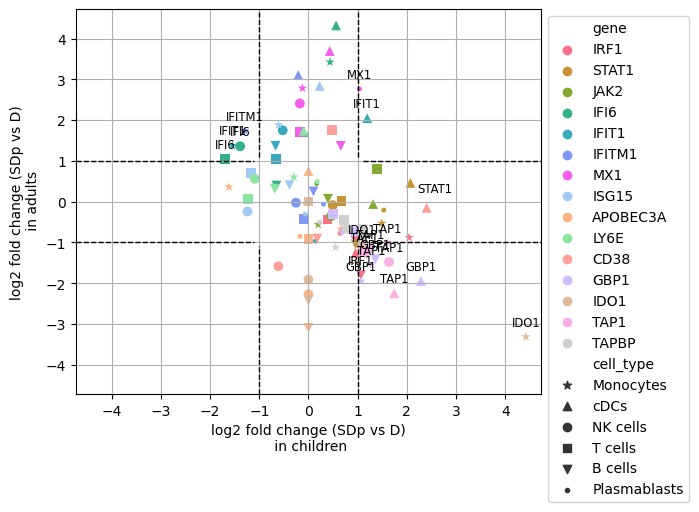

In [26]:
cts=['Monocytes', 'cDCs', 'NK cells', 'T cells', 'B cells', 'Plasmablasts']
figsize=[6,5]
genes = ['IRF1', 'STAT1', 'JAK2', 
         'IFI6', 'IFIT1', 'IFITM1', 'MX1', 'ISG15', 'APOBEC3A', #'IFI44L', 
         'LY6E', 'CD38',
         'GBP1', 'IDO1', 'TAP1', 'TAPBP'
        ]


import textalloc as ta
from adjustText import adjust_text
import matplotlib as mpl
from matplotlib.patches import Ellipse
sc_col='children'
cy_col='adults'

title = 'Severe dengue vs Dengue'
fig, ax = plt.subplots(figsize=figsize)
hue_order=['upregulated_both', 'downregulated_both', 'upregulated_either', 'no', 'downregulated_either', 'reverse', ]
palette=['orange', 'orange', 'gray', 'gray', 'gray', 'orange']
    
markers = {}
allmarkers = ['.', 'v', 's', 'o', '^', '*']
for ct in cts:
    markers[ct] = allmarkers.pop()


all_stats = all_stats2.loc[cts]
all_stats = all_stats.reset_index().set_index(['gene'])
all_stats = all_stats.loc[genes]
all_stats['size'] = [10 if x == 'no' else 30 for x in all_stats.DEG]
df=all_stats.reset_index()
#df['genes'] = list(df.reset_index()['gene'])


sns.scatterplot(data=df, x=sc_col, y=cy_col, ax=ax, hue='gene', 
                #hue_order=hue_order,
                style = 'cell_type', 
                    markers= markers, #size = 10,
                palette=sns.color_palette("husl",7)+sns.color_palette("pastel", 8), 
                edgecolor='none', s=50)
  
genes = df[df.DEG.isin(['upregulated_both','downregulated_both', 'reverse'])].index.to_list()
for gene in genes:
    ax.text(df[sc_col][gene]+0., df[cy_col][gene]+0.2, df['gene'][gene], ha='center', va='bottom', size='small')

gene=7
ax.text(df[sc_col][gene]+0.5, df[cy_col][gene]-0.3, df['gene'][gene], ha='center', va='bottom', size='small')
gene=30
#ax.text(df[sc_col][gene]+0., df[cy_col][gene]-0.4, df['gene'][gene], ha='center', va='bottom', size='x-small')


ax.grid(True)
ax.set_xlabel('log2 fold change (SDp vs D)\n in children')
ax.set_ylabel('log2 fold change (SDp vs D)\n in adults')
    
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
lim = max(abs(xmin), abs(xmax), abs(ymin), abs(ymax))

ax.set_xlim(-1*lim, lim)
ax.set_xticks(range(-1*int(lim),int(lim)+1,1))
ax.set_ylim(-1*lim, lim)
ax.set_yticks(range(-1*int(lim),int(lim)+1,1))
    
ax.axhline(y = 1, xmin=0, xmax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axhline(y = -1, xmin=0, xmax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axhline(y = 1, xmin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axhline(y = -1, xmin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axvline(x = 1, ymin=0, ymax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axvline(x = -1, ymax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axvline(x = 1, ymin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axvline(x = -1, ymin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)

ax.legend(bbox_to_anchor=(1, 1))
fig.savefig(save_figures + f'ISGs_across_celltypes.svg', bbox_inches='tight', dpi=300)
plt.show()
